#  ALS Recommendation System

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from numpy.linalg import solve
%matplotlib inline


In [175]:
rating  = pd.read_csv("file:///Users/qiankunhuang/Downloads/ml-latest-small/ratings.csv")
rating.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# Create ratings matrix
table = pd.pivot_table(rating,index = "userId" ,columns="movieId",values = "rating")
ratings = table.fillna(value=0).as_matrix()
ratings.shape

# MY ALS

In [219]:
def get_mse(q,X,Y):
        return np.square(q-np.dot(X,Y)).mean()
def myals(lambda_,n_factors,ratings,n_iterations):
    m,n=ratings.shape
    X= 10*np.random.rand(m,n_factors)
    Y= 10*np.random.rand(n_factors,n)
    l=[]
    for i in xrange(n_iterations):
        YYT = np.dot(Y,Y.T)
        YRT=  np.dot(Y,ratings.T)
        X= np.linalg.solve(YYT + lambda_* np.eye(n_factors),
                      YRT).T
        XTX = np.dot(X.T,X)
        XTR = np.dot(X.T,ratings)
        Y= np.linalg.solve(XTX+lambda_* np.eye(n_factors),
                      XTR)
        if i % 3 == 0:
            mse = get_mse(ratings,X,Y)
            l.append(mse)
            print("iteration" + format(i))
            print ("Train mse" + str(mse))
    plt.plot(l)
        
    

iteration0
Train mse0.212827914514
iteration3
Train mse0.117317858021
iteration6
Train mse0.116092263364
iteration9
Train mse0.115756978153
iteration12
Train mse0.11559387238
iteration15
Train mse0.115508308747
iteration18
Train mse0.115463657903


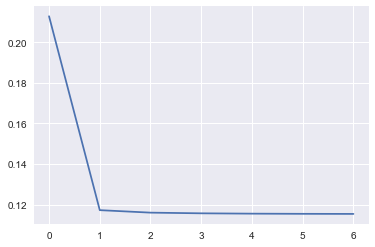

In [220]:
lambda_ = 0.1
n_factors=30
n_iteration=21
myals(lambda_,n_factors,ratings,n_iteration)

#### conclusion : This code works well ,after 10 iterarions it becomes convergent.

# Class ALS

In [98]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [210]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
 
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        if type == 'user':
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                     ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):

        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        ctr=1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    def get_mse(self,pred,y):
        return np.square(pred-y).mean()
    def calculate_learning_curve(self, iter_array):
        iter_array.sort()
        self.train_mse =[]
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [self.get_mse(predictions, self.ratings)]
            #self.test_mse += [self.get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                #print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter
        plt.plot(self.train_mse)
                

Iteration: 1
Train mse: 0.154182280971
Iteration: 4
Train mse: 0.117524474032
Iteration: 7
Train mse: 0.116100241219
Iteration: 10
Train mse: 0.115737892339
Iteration: 13
Train mse: 0.11559062389
Iteration: 16
Train mse: 0.115519332251
Iteration: 19
Train mse: 0.115481796606


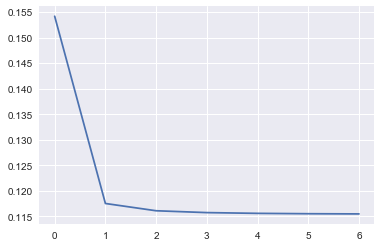

In [227]:
MF_ALS = ExplicitMF(ratings, n_factors=30,\
                    user_reg=0.1, item_reg=0.1,verbose=True)

MF_ALS.calculate_learning_curve(np.arange(1,21,3))

#### conclusion : This result is almost the same as the previous one, after 10 iterarions it becomes convergent.

# spark

In [234]:
from pyspark.mllib.recommendation import ALS,MatrixFactorizationModel,Rating
import time
data = sc.textFile("file:///Users/qiankunhuang/Downloads/ml-latest-small/ratings.csv")
ratings = data.map(lambda i : i.split(","))
head = ratings.first()
ratings=ratings.filter(lambda x: x != head)
ratings = ratings.map(lambda I: Rating(int(I[0]),int(I[1]),float(I[2])))
train,validation = ratings.randomSplit([8,2])
traindatat =train.map(lambda p:(p[0],p[1]))
validata = validation.map(lambda p:(p[0],p[1]))

In [236]:
ranks = [5,10,15,20]
iterations = 20
reg= [0.1,0.2,0.3]
for i in ranks:
    for j in reg:
        tic = time.clock()
        model = ALS.train(ratings,i,20,j)
        prediction = model.predictAll(validata).map(lambda r:((r[0],r[1]),r[2]))
        rateAndPreds = validation.map(lambda r:((r[0],r[1]),r[2])).join(prediction)
        MSE = rateAndPreds.map(lambda r:(r[1][0]-r[1][1])**2).mean()
        toc = time.clock()
        print i,j
        print ("mean squared error=" + str(MSE))
        print ("time =" + format(toc-tic))


5 0.1
mean squared error=0.450281265359
time =0.174567
5 0.2
mean squared error=0.566412004269
time =0.093537
5 0.3
mean squared error=0.699421442338
time =0.067268
10 0.1
mean squared error=0.356205032962
time =0.0701300000001
10 0.2
mean squared error=0.543476763444
time =0.063388
10 0.3
mean squared error=0.699246774854
time =0.0617829999999
15 0.1
mean squared error=0.314182898796
time =0.066818
15 0.2
mean squared error=0.536795853308
time =0.0695409999998
15 0.3
mean squared error=0.698847784592
time =0.0639620000002
20 0.1
mean squared error=0.287816348323
time =0.0659800000001
20 0.2
mean squared error=0.534310942384
time =0.0635560000001
20 0.3
mean squared error=0.698842153296
time =0.0669929999999


#### Conclusion： More iterations will decrease the MSE and  smaller lambda will decrease the MSE according to this data.